100%|██████████| 10.0/10.0 [00:16<00:00,  1.64s/it]        


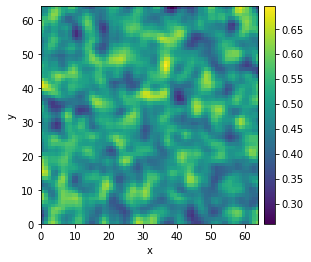

In [2]:
import pde

grid = pde.UnitGrid([64, 64])                 # generate grid
state = pde.ScalarField.random_uniform(grid)  # generate initial condition

eq = pde.DiffusionPDE(diffusivity=0.1)        # define the pde
result = eq.solve(state, t_range=10)          # solve the pde
result.plot()                                 # plot the resulting field

# Example of custom equation:

Korteweg-de Vries equation:

$$\partial_t \phi = 6\phi\partial_x \phi - \partial_{x}^{3}\phi$$

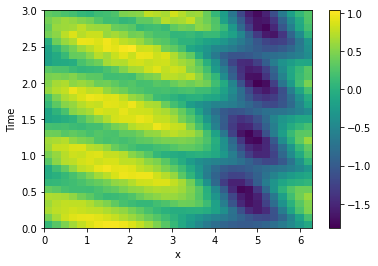

In [3]:
from numpy import pi
eq = pde.PDE(
    {"phi": "6 * phi * get_x(gradient(phi)) - laplace(get_x(gradient(phi)))"},
    user_funcs={"get_x": lambda arr: arr[0]}
)

grid = pde.CartesianGrid([[0, 2 * pi]], [32], periodic=True)
state = pde.ScalarField.from_expression(grid, "sin(x)")

# solve & store
storage = pde.MemoryStorage()
eq.solve(state, t_range=3, tracker=storage.tracker(0.1))

# plot
pde.plot_kymograph(storage)

# My first try using custom equation:

Burgers' Equation:

$$
\partial_t u + u\partial_x u = 0; \qquad u(0, x) = f(x)
$$
Boundary & Initial Conditions
$$
f(x) = -sin(x)\\
u(t, x=-1) = u(t, x=+1) = 0
$$

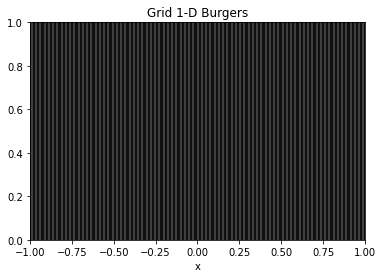

In [19]:
#bc_left = {"value": 0}
#bc_right = {"value": 0}
bc = {"value": 0}#[bc_left, bc_right]
grid = pde.CartesianGrid([[-1,+1]],[256], periodic=False)
grid.plot(title=f'Grid 1-D Burgers')

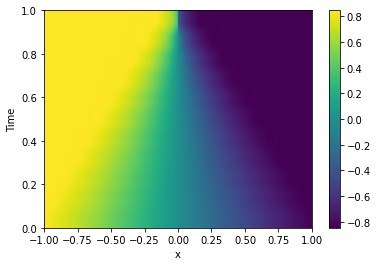

In [22]:
state = pde.ScalarField.from_expression(grid, "-sin(x)")

# equation

eq = pde.PDE(
    {"u": "-u * get_x(gradient(u))"},
    user_funcs={"get_x": lambda arr: arr[0]}
)

# solve & store
storage = pde.MemoryStorage()
eq.solve(state, t_range=1, dt=1e-4, tracker=storage.tracker(0.1)) # t_range > 1 gives error, why?

# plot
pde.plot_kymograph(storage)

# Euler Equation ???

$$
\partial_t\rho = -u\partial_x \rho - \rho \partial_x u \\
\partial_t u = -u\partial_x u - \rho^{-1}\partial_x p \\
\partial_t p = - \gamma p \partial_x u - u \partial_x p
$$
where $\gamma$ is the heat capacity ratio.

Boundary & Initial Conditions (Domain: $x \in [0,1], t \in [0,0.2]$)

$$
i.c.: \left \{\begin{array}{ c l }
    \rho = 1  \\
    u = 0.9 & \quad \textrm{if } x \leq 0.5, 0 \quad \textrm{otherwise}\\
    p = 1 & \quad \textrm{if } x \leq 0.5, 10 \quad \textrm{otherwise}
  \end{array}
\right.
$$

using [this as reference](https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_sir.html)




Initializing:   0%|          | 0/0.2 [00:00<?, ?it/s]

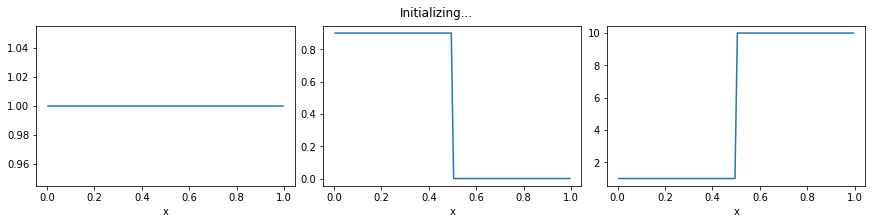

  0%|          | 0/0.2 [00:00<?, ?it/s]              

<Figure size 432x288 with 0 Axes>

  8%|▊         | 0.016/0.2 [00:01<00:18, 98.31s/it]/Users/idal/Documents/GitHub/astropinns/.venv/lib/python3.8/site-packages/pde/fields/base.py:501: RuntimeWarning: overflow encountered in multiply
  op(self.data, other.data, out=result.data)
/Users/idal/Documents/GitHub/astropinns/.venv/lib/python3.8/site-packages/pde/fields/base.py:501: RuntimeWarning: invalid value encountered in multiply
  op(self.data, other.data, out=result.data)
/Users/idal/Documents/GitHub/astropinns/.venv/lib/python3.8/site-packages/pde/solvers/explicit.py:115: RuntimeWarning: invalid value encountered in add
  state_data += dt * rhs_pde(state_data, t)
 16%|█▌        | 0.032/0.2 [00:01<00:08, 49.41s/it]/Users/idal/Documents/GitHub/astropinns/.venv/lib/python3.8/site-packages/pde/fields/base.py:501: RuntimeWarning: invalid value encountered in subtract
  op(self.data, other.data, out=result.data)
100%|██████████| 0.2/0.2 [00:01<00:00,  8.34s/it]  


In [37]:
import numpy as np
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, CartesianGrid

class EulerPDE(PDEBase):
    """Non-relativistic 1D Euler Equations"""

    def __init__(self, hcr = 1.4, bc="auto_periodic_dirichlet"):
        # no bc given so...
        self.hcr = hcr
        self.bc = bc #needed for gradient
    
    def get_state(self, rho, u, p):
        """generate a suitable initial state"""
        return FieldCollection([rho, u, p])
    
    def evolution_rate(self, state, t: float = 0):
        rho, u, p = state
        hcr = self.hcr
        get_x = lambda arr: arr[0]
        drho_dt = -u*get_x(rho.gradient(self.bc)) -rho*get_x(u.gradient(self.bc))
        du_dt = -u*get_x(u.gradient(self.bc)) -(1/rho)*get_x(p.gradient(self.bc))
        dp_dt = -hcr*p*get_x(u.gradient(self.bc)) -u*get_x(p.gradient(self.bc))
        return FieldCollection([drho_dt, du_dt, dp_dt])


eq = EulerPDE(hcr=1.4)

# Initial State
nx = 100
tstep = 0.2/400
x = np.linspace(0,1,nx)
ic_u = lambda x: 0.9*(x<=0.5)
ic_p = lambda x: 1*(x<=0.5) + 10*(x>0.5)
grid = CartesianGrid([[0,1]],[nx])
rho = ScalarField(grid, 1)
u = ScalarField(grid, ic_u(x))
p = ScalarField(grid, ic_p(x))
state = eq.get_state(rho, u, p)

# simulate
tracker = PlotTracker(interval=1)
sol = eq.solve(state, t_range=0.2, dt=0.002, tracker=["progress", tracker])

In [30]:
import numpy as np
nx = 32
x = np.linspace(0,1,nx)
ic_p = lambda x: 1*(x<=0.5) + 10*(x>0.5)
ic_p(x)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])